<a href="https://colab.research.google.com/github/FUHannes/Deep-Learning/blob/main/Ex04/TL_Hannes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [105]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cifar-3 Image classification Challenge
Adapted from official tensorflow image classification tutorial: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb

## Imports and Constants

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import constraints

In [107]:
with np.load('prediction-challenge-02-data.npz') as fh:
    challenge_x_train = fh['x_train']
    challenge_y_train = fh['y_train']
    challenge_x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(f"Training data shape: {challenge_x_train.shape}, type: {challenge_x_train.dtype}")
print(f"Training labels shape: {challenge_y_train.shape}, type: {challenge_y_train.dtype}")

# TEST DATA: INPUT (x) ONLY
print(f"Test data shape: {challenge_x_test.shape}, type: {challenge_x_test.dtype}")

Training data shape: (3000, 32, 32, 3), type: float32
Training labels shape: (3000,), type: float64
Test data shape: (300, 32, 32, 3), type: float32


In [108]:
BATCH_SIZE = 32
IMG_HEIGHT = challenge_x_train.shape[1]
IMG_WIDTH = challenge_x_train.shape[2]
VAL_SIZE = 0.2
TEST_SIZE = 0.1
CLASSES = {0:"cat",1:"dog",2:"frog"}
NUM_CLASSES = len(CLASSES)

## Visualize Examples

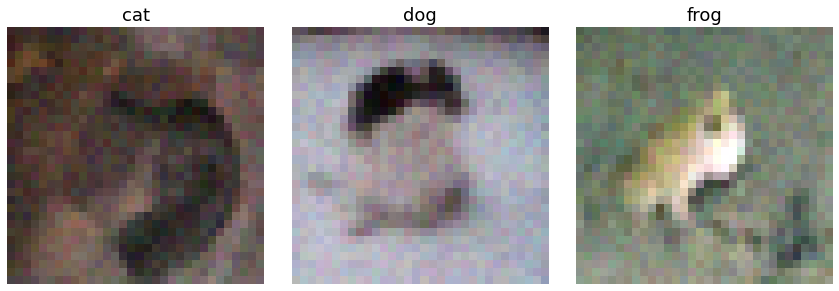

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=len(CLASSES), figsize=(4*len(CLASSES), 4))

for class_id in CLASSES:
    axes[class_id].set_title(CLASSES[class_id], size=18)
    axes[class_id].imshow(challenge_x_train[np.where(challenge_y_train == class_id)[0][0]])
    axes[class_id].axis("off")
fig.tight_layout()
plt.show()

## Training - Validation - Test - Split

In [110]:
x, x_test, y, y_test = train_test_split(challenge_x_train,challenge_y_train, test_size=TEST_SIZE,shuffle=True,random_state=71,stratify=challenge_y_train)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=VAL_SIZE, shuffle=True, stratify=y)

x = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

## Data augmentation

In [111]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.7,1.0),
    shear_range=10,
    zoom_range=(0.8,1.0),
    horizontal_flip=True,
    rotation_range=90., 
    validation_split=VAL_SIZE)

img_gen.fit(x)
train_ds = img_gen.flow(x,y,batch_size=BATCH_SIZE,shuffle=True,seed=28, subset="training")
val_ds = img_gen.flow(x,y,batch_size=BATCH_SIZE,shuffle=True,seed=28, subset="validation")

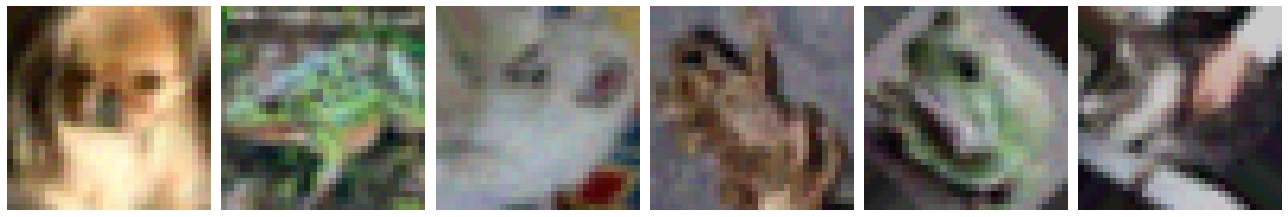

In [112]:
fig, rows =plt.subplots(nrows=1, ncols=6, figsize=(18,18))
for row in rows:
    row.imshow(train_ds.next()[0][10].astype(np.uint8))
    row.axis("off")
    
plt.tight_layout()
plt.show()

## Model Definition

In [113]:
model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

## transfer learning

In [114]:
# load pretrained model and specify a new input shape for images
new_input = keras.Input(shape=(32, 32, 3))
model_orig = keras.applications.vgg16.VGG16(include_top=False, input_tensor=new_input)

In [115]:
# freeze known layers
model_orig.trainable=False

In [116]:
# our new shallow classifier
flat1 = layers.Flatten()(model_orig.layers[-1].output)
class1 = layers.Dense(512, activation='relu')(flat1)
dropout = layers.Dropout(0.3)(class1)
output = layers.Dense(3, activation='softmax')(dropout)

In [117]:
# complete model
model = keras.Model(inputs=model_orig.inputs, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [118]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training

In [119]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
    batch_size=BATCH_SIZE,
  epochs=epochs
)

Epoch 1/30
68/68 [==============================] - 3s 33ms/step - loss: 9.9874 - accuracy: 0.4663 - val_loss: 3.6569 - val_accuracy: 0.5907
Epoch 2/30
68/68 [==============================] - 2s 31ms/step - loss: 3.4646 - accuracy: 0.5897 - val_loss: 2.2863 - val_accuracy: 0.5926
Epoch 3/30
68/68 [==============================] - 2s 30ms/step - loss: 2.1937 - accuracy: 0.6107 - val_loss: 2.0588 - val_accuracy: 0.5500
Epoch 4/30
68/68 [==============================] - 2s 30ms/step - loss: 1.5177 - accuracy: 0.6361 - val_loss: 1.5712 - val_accuracy: 0.6185
Epoch 5/30
68/68 [==============================] - 2s 29ms/step - loss: 1.0949 - accuracy: 0.6553 - val_loss: 1.2111 - val_accuracy: 0.6241
Epoch 6/30
68/68 [==============================] - 2s 29ms/step - loss: 0.9573 - accuracy: 0.6515 - val_loss: 1.1697 - val_accuracy: 0.5870
Epoch 7/30
68/68 [==============================] - 2s 30ms/step - loss: 0.7844 - accuracy: 0.6823 - val_loss: 1.0686 - val_accuracy: 0.6222
Epoch 8/30
68

In [120]:
# fine tuning top 8 layers
for layer in model.layers[:-8]:
    layer.trainable = False
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
    batch_size=BATCH_SIZE,
  epochs=epochs
)

Epoch 1/10
68/68 [==============================] - 3s 32ms/step - loss: 0.4983 - accuracy: 0.7858 - val_loss: 1.0234 - val_accuracy: 0.6204
Epoch 2/10
68/68 [==============================] - 2s 28ms/step - loss: 0.4687 - accuracy: 0.8140 - val_loss: 1.0742 - val_accuracy: 0.6167
Epoch 3/10
68/68 [==============================] - 2s 28ms/step - loss: 0.5170 - accuracy: 0.7756 - val_loss: 1.0484 - val_accuracy: 0.6167
Epoch 4/10
68/68 [==============================] - 2s 29ms/step - loss: 0.4966 - accuracy: 0.8045 - val_loss: 1.1500 - val_accuracy: 0.6093
Epoch 5/10
68/68 [==============================] - 2s 28ms/step - loss: 0.4834 - accuracy: 0.8005 - val_loss: 1.0752 - val_accuracy: 0.6241
Epoch 6/10
68/68 [==============================] - 2s 29ms/step - loss: 0.4883 - accuracy: 0.8171 - val_loss: 1.0567 - val_accuracy: 0.6296
Epoch 7/10
68/68 [==============================] - 2s 28ms/step - loss: 0.4951 - accuracy: 0.7964 - val_loss: 1.0455 - val_accuracy: 0.6130
Epoch 8/10
68

## Visualize Metrics

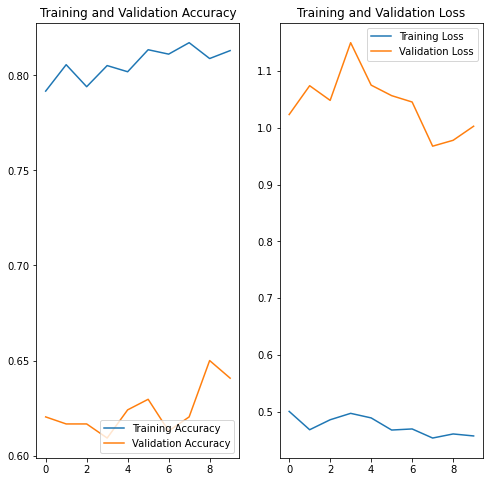

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction with Test Time Augmentation 

Adapted from a blogpost: https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d 

In [122]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(img_gen.flow(x_test, batch_size=BATCH_SIZE, shuffle=False))
    scores = tf.nn.softmax(preds)
    predictions.append(scores)

pred = np.mean(predictions, axis=0)

print(f"Accuracy on custom test set: {np.mean(np.equal(y_test, np.argmax(pred, axis=1)))}")

Accuracy on custom test set: 0.6733333333333333


## Continue Training with whole Dataset

In [123]:
whole_train_ds = img_gen.flow(challenge_x_train,challenge_y_train,batch_size=BATCH_SIZE,shuffle=True, subset="training")
whole_val_ds = img_gen.flow(challenge_x_train,challenge_y_train,batch_size=BATCH_SIZE,shuffle=True, subset="validation")
epochs = 10
history = model.fit(
  whole_train_ds,
  validation_data=whole_val_ds,
    batch_size=BATCH_SIZE,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 2s 30ms/step - loss: 0.6530 - accuracy: 0.7588 - val_loss: 0.6461 - val_accuracy: 0.7867
Epoch 2/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6190 - accuracy: 0.7533 - val_loss: 0.6189 - val_accuracy: 0.7867
Epoch 3/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6000 - accuracy: 0.7679 - val_loss: 0.6384 - val_accuracy: 0.7883
Epoch 4/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6438 - accuracy: 0.7633 - val_loss: 0.6164 - val_accuracy: 0.7967
Epoch 5/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6419 - accuracy: 0.7496 - val_loss: 0.6222 - val_accuracy: 0.7600
Epoch 6/10
75/75 [==============================] - 2s 28ms/step - loss: 0.6310 - accuracy: 0.7579 - val_loss: 0.6057 - val_accuracy: 0.7833
Epoch 7/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6129 - accuracy: 0.7663 - val_loss: 0.6291 - val_accuracy: 0.7883
Epoch 8/10
75

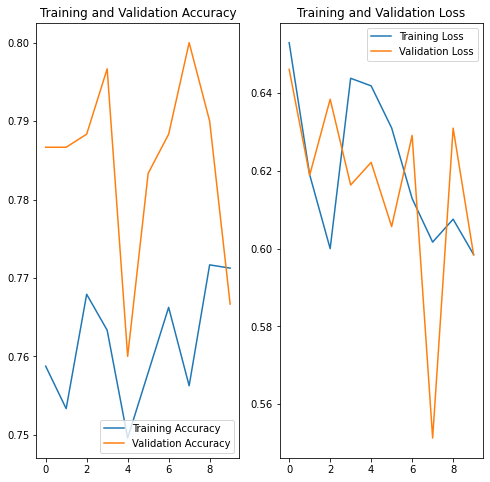

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Challenge Prediction with Test Time Augmentation

In [125]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(img_gen.flow(challenge_x_test, batch_size=BATCH_SIZE, shuffle=False))
    scores = tf.nn.softmax(preds)
    predictions.append(scores)

pred = np.mean(predictions, axis=0)
prediction = np.argmax(pred,axis=1)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
    
validate_prediction_format()

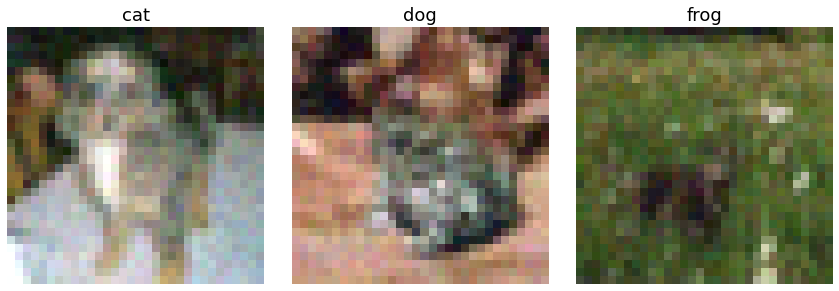

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=len(CLASSES), figsize=(4*len(CLASSES), 4))

for class_id in CLASSES:
    axes[class_id].set_title(CLASSES[class_id], size=18)
    axes[class_id].imshow(challenge_x_test[np.where(prediction == class_id)[0][0]])
    axes[class_id].axis("off")
fig.tight_layout()
plt.show()